# Model Evaluation Notebook

This notebook evaluates the performance of the trained transformer model against baseline methods.

## Setup and Data Loading

In [1]:
import sys

sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
import core
import os

# Configuration
if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
elif True:
    PLOTS_DIR = "plots/RegressionTransformer_nu_flows_neutrino_only/"
    MODEL_DIR = "../models/regression_transformer/"
else:
    PLOTS_DIR = "plots/RegressionTransformer_/"
    MODEL_DIR = "../models/regression_transformer_old/"


CONFIG_PATH = "../config/workspace_config.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 18})

from core.utils import lorentz_vector_from_PtEtaPhiE_array
from core.evaluation import c_hel, c_han

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)
data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], event_numbers="odd"
)
PREDICTIONS_DIR = os.path.join(load_config.data_dir, "RegressionTransformer_nu_flows_neutrino_only", "odd_predictions/")
DataProcessor.add_custom_feature(
    (
        lambda X, data_config: c_hel(
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 1, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 1, :4]),
        )
    ),
    "c_hel",
)
DataProcessor.add_custom_feature(
    (
        lambda X, data_config: c_han(
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 1, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 1, :4]),
        )
    ),
    "c_han",
)

X, y = DataProcessor.get_data()
del DataProcessor

2026-01-20 15:49:29.515872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768920569.538256  754827 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768920569.545593  754827 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768920569.563165  754827 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768920569.563182  754827 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768920569.563185  754827 computation_placer.cc:177] computation placer alr

## Load Model and Setup Evaluator

In [2]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation.reconstruction_evaluator as Evaluation
from core.reconstruction import (
    GroundTruthReconstructor,
    PerfectAssignmentReconstructor,
    CompositeNeutrinoComponentReconstructor,
)

reload(Evaluation)
reload(BaselineMethods)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
perfect_assigner = PerfectAssignmentReconstructor(
    data_config, neutrino_reco_name=r"Transformer $\nu$"
)
MODEL_DIR = "../models/regression_transformer/"
perfect_assigner.load_model(f"{MODEL_DIR}/model.keras")

prediction_manager = Evaluation.PredictionManager(
    [ground_truth_assigner, perfect_assigner], X, y, load_directory=PREDICTIONS_DIR
)

evaluator = Evaluation.ReconstructionEvaluator(prediction_manager)

I0000 00:00:1768920803.420704  754827 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14423 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from ../models/regression_transformer//model.keras
Training history loaded from ../models/regression_transformer//model_history.npz
Predictions loaded for True Assignment + $\nu^2$-Flows.
Predictions loaded for True Assignment + Transformer $\nu$.


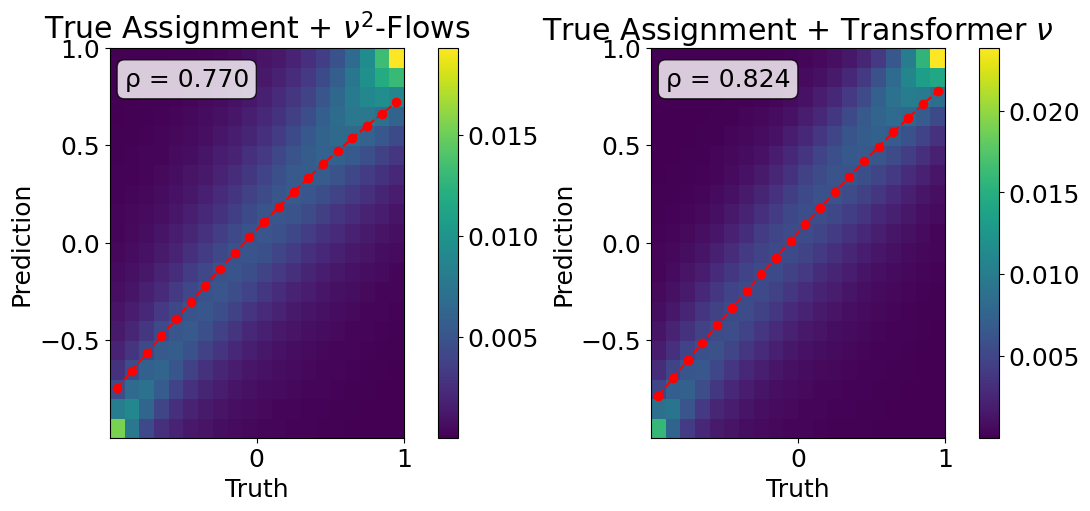

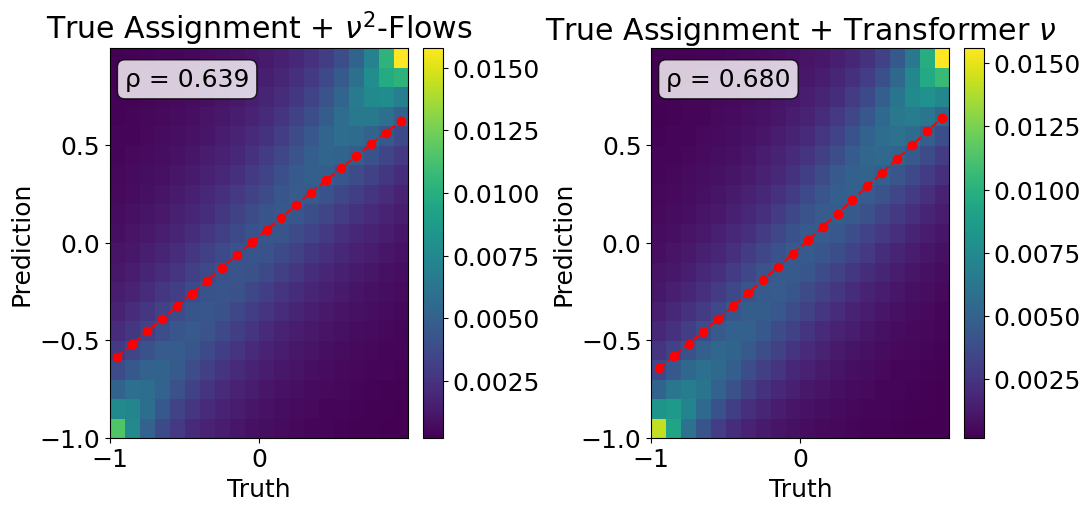

In [3]:
fig, ax = evaluator.plot_variable_confusion_matrix(
    "c_hel", normalize="all", figsize_per_plot=(5.4, 5), bins=20, plot_mean=True
)
fig.savefig(os.path.join(PLOTS_DIR, "c_hel_confusion_matrix.pdf"))

fig, ax = evaluator.plot_variable_confusion_matrix(
    "c_han", normalize="all", figsize_per_plot=(5.4, 5), bins=20, plot_mean=True
)
fig.savefig(os.path.join(PLOTS_DIR, "c_han_confusion_matrix.pdf"))


Computing binned Mean Relative $m(t\overline{t})$ Deviation for truth_ttbar_mass...

Computing binned Mean Relative $m(t)$ Deviation for truth_ttbar_mass...

Computing binned Relative $m(t\overline{t})$ Resolution for truth_ttbar_mass...
Using cached reconstructed variable 'ttbar_mass' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'ttbar_mass' for reconstructor True Assignment + Transformer $\nu$.

Computing binned Relative $m(t)$ Resolution for truth_ttbar_mass...
Using cached reconstructed variable 'top_mass' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'top_mass' for reconstructor True Assignment + Transformer $\nu$.


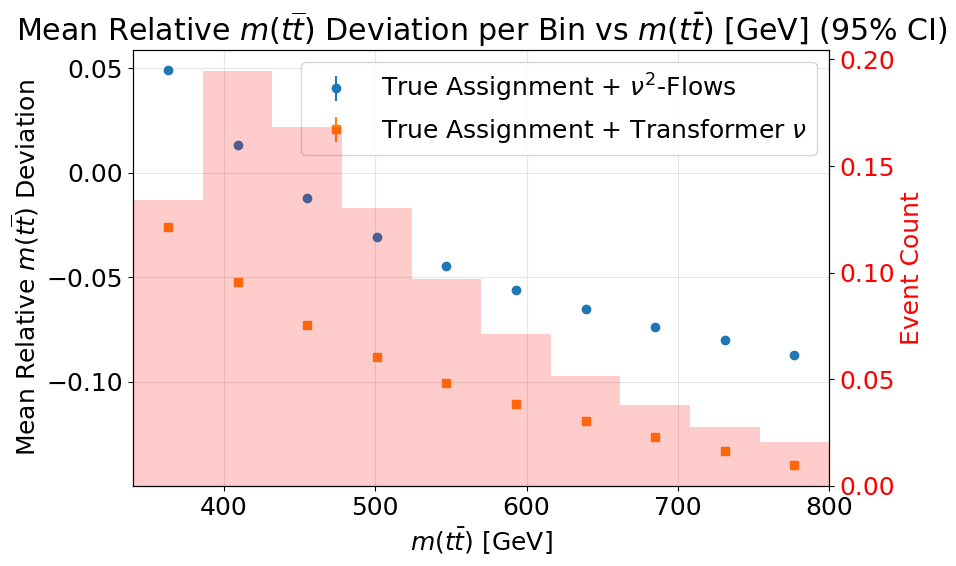

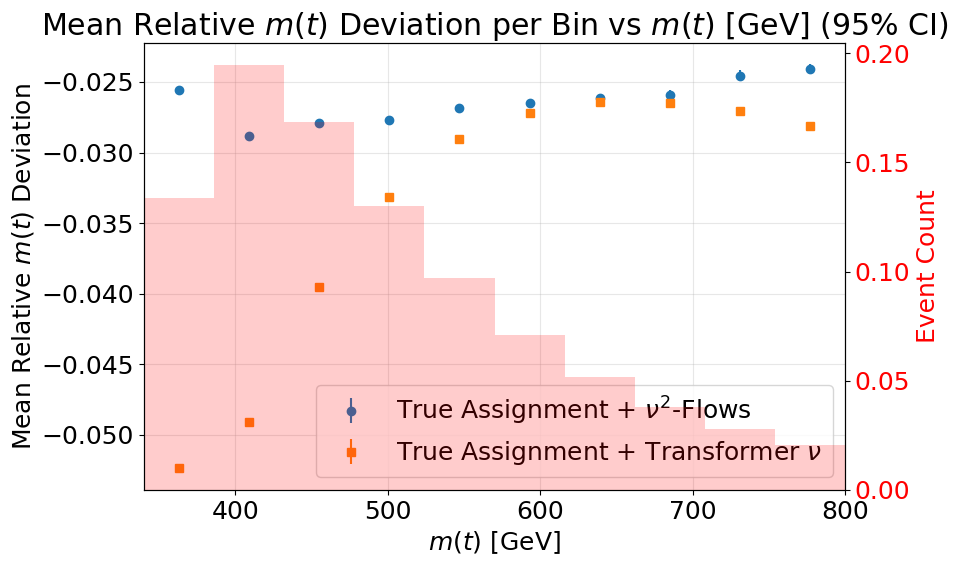

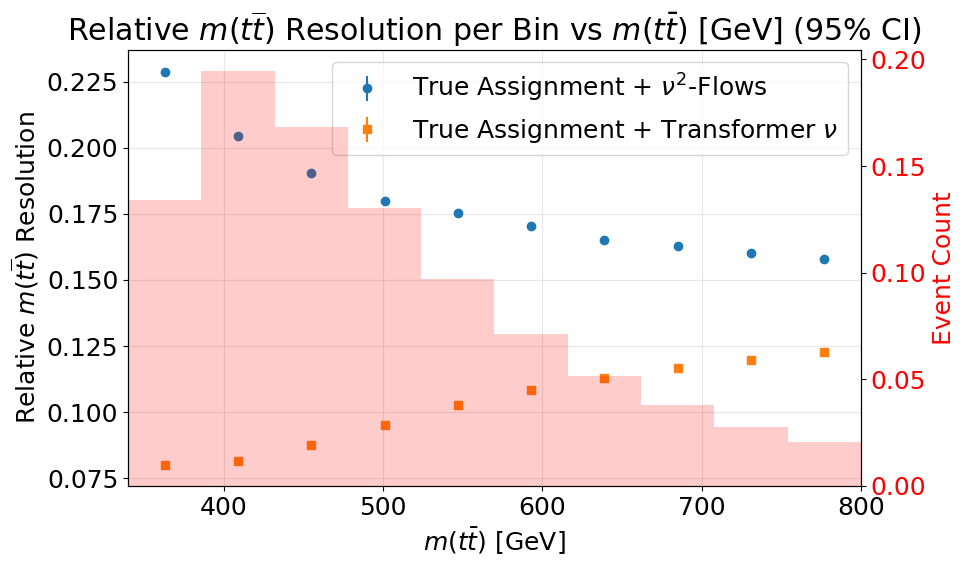

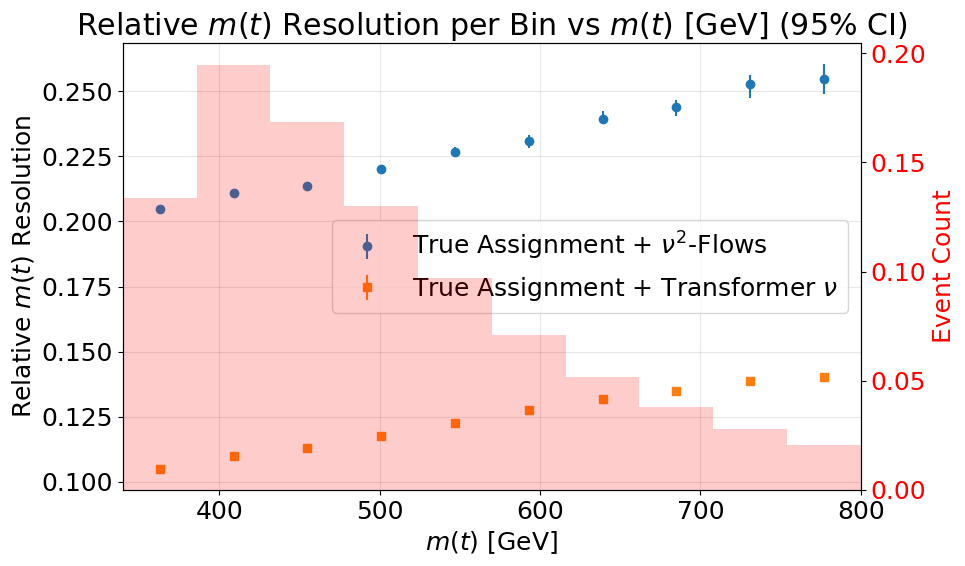

In [4]:
fig, ax = evaluator.plot_binned_variable(
    "ttbar_mass",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "top_mass",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t)$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/top_mass_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "ttbar_mass",
    "resolution",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_resolution_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "top_mass",
    "resolution",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t)$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/top_mass_resolution_vs_ttbar_mass.pdf", bbox_inches="tight")


Computing binned Mean $c_{\text{hel}}$ Deviation for truth_ttbar_mass...
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.

Computing binned Mean $c_{\text{han}}$ Deviation for truth_ttbar_mass...
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.

Computing binned $c_{\text{hel}}$ Resolution for truth_ttbar_mass...
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.

Computing binned $c_{\text{han}}$ Resolution for truth_ttbar_mass...
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable

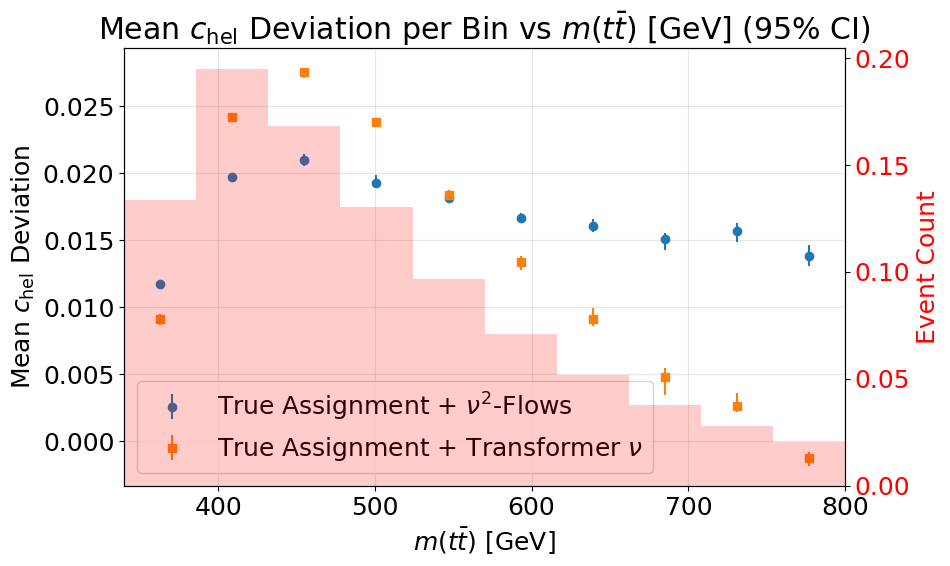

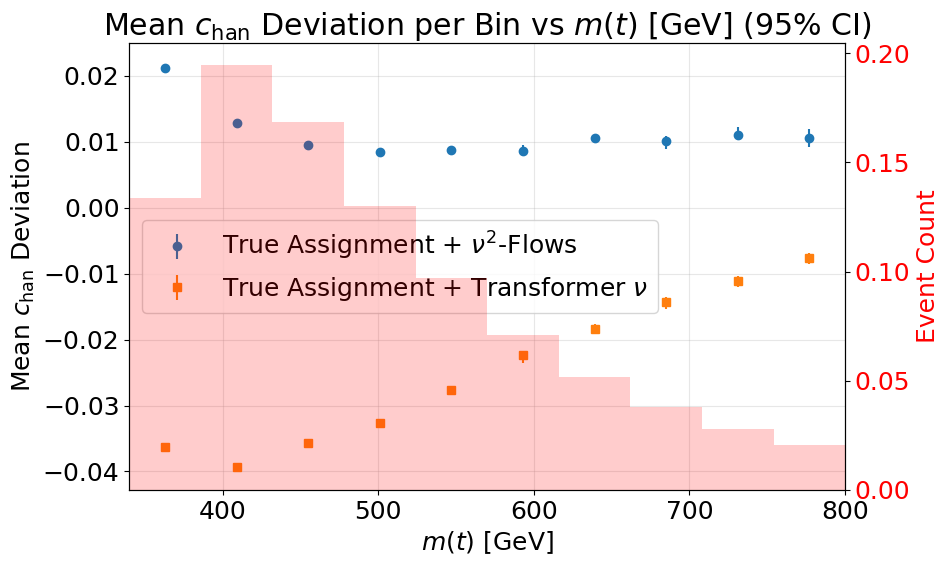

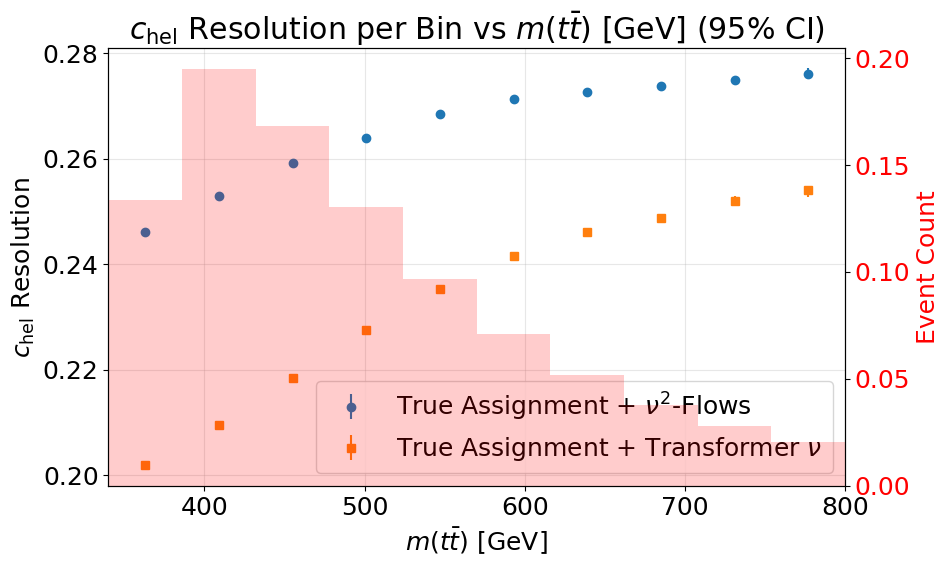

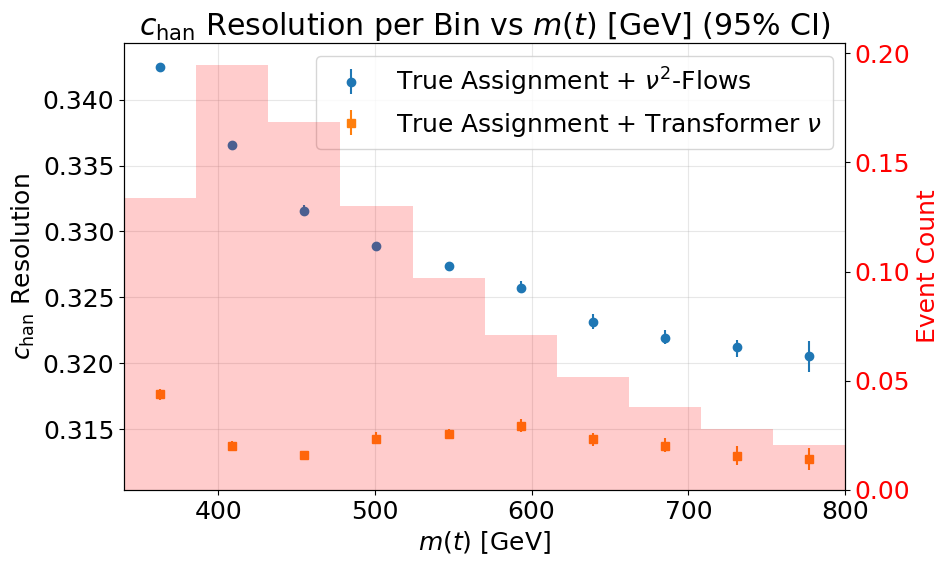

In [5]:
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_hel_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t)$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_han_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "resolution",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_hel_resolution_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "resolution",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t)$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_han_resolution_vs_ttbar_mass.pdf", bbox_inches="tight")


Computing binned Mean $c_{\text{hel}}$ Deviation for c_hel...
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.

Computing binned Mean $c_{\text{han}}$ Deviation for c_han...
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.


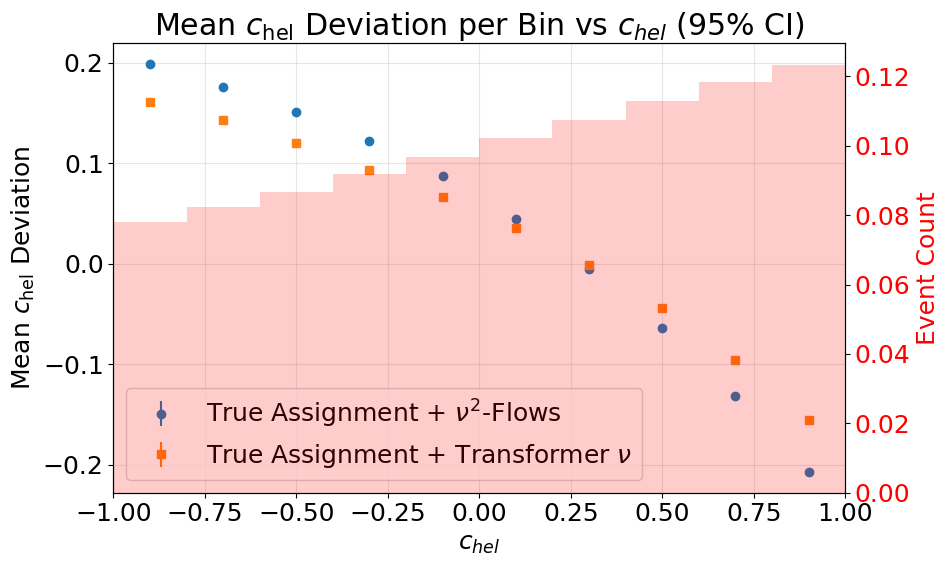

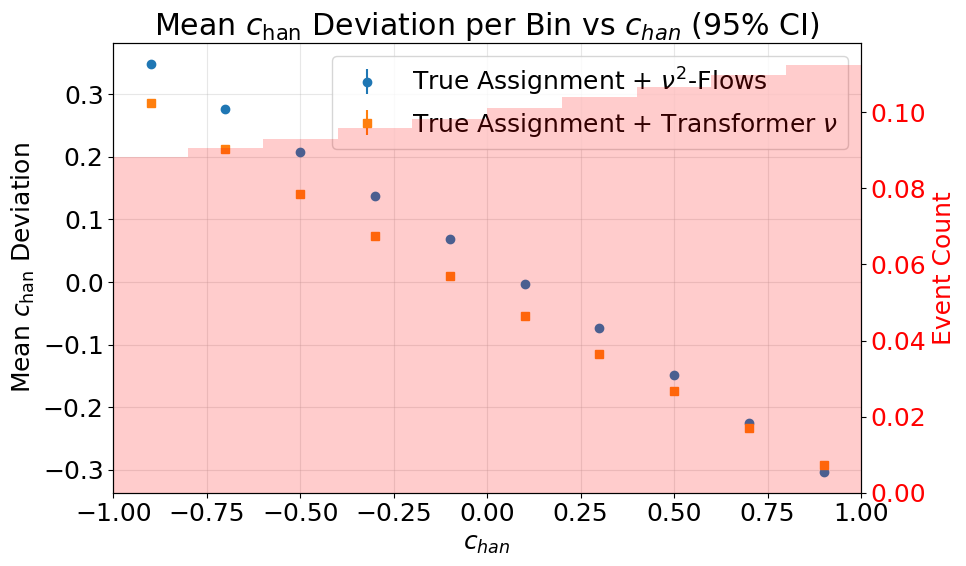

In [6]:
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "deviation",
    "custom",
    "c_hel",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{hel}$",
)
fig.savefig(f"{PLOTS_DIR}/c_hel_deviation_vs_c_hel.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "deviation",
    "custom",
    "c_han",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{han}$",
)
ticks = ax.get_xticks()
fig.savefig(f"{PLOTS_DIR}/c_han_deviation_vs_c_han.pdf", bbox_inches="tight")


Computing binned $c_{\text{hel}}$ Resolution for c_hel...
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.

Computing binned $c_{\text{han}}$ Resolution for c_han...
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.


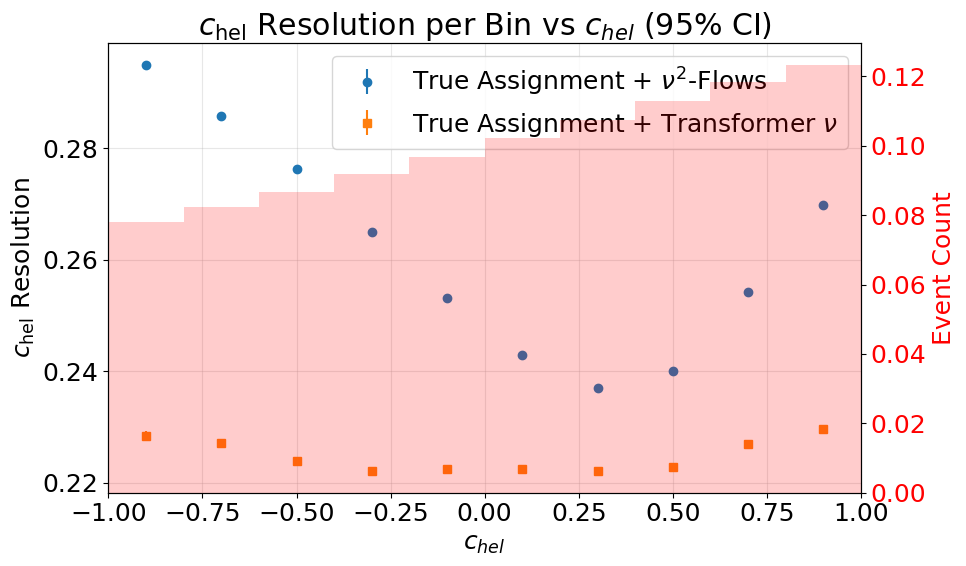

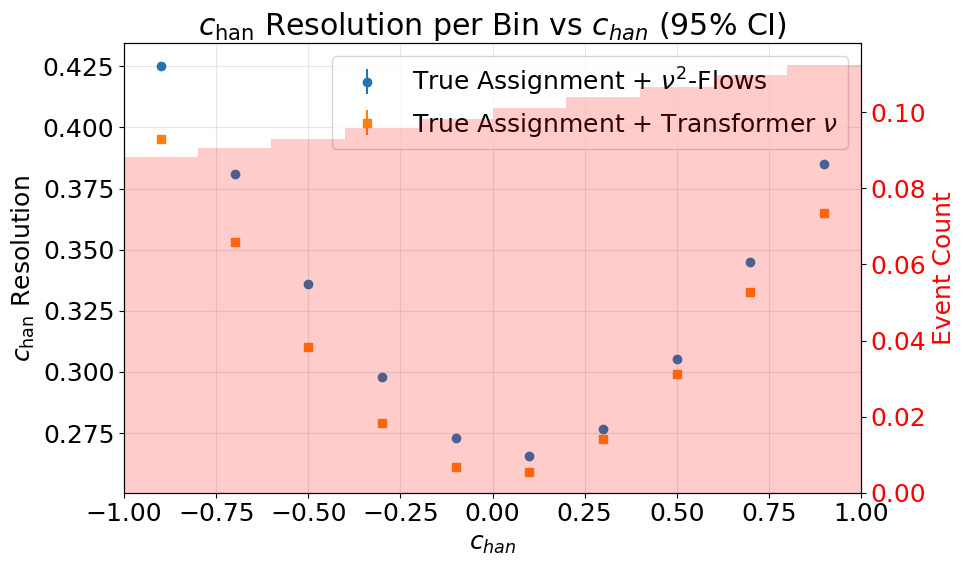

In [7]:
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "resolution",
    "custom",
    "c_hel",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{hel}$",
)
fig.savefig(f"{PLOTS_DIR}/c_hel_resolution_vs_c_hel.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "resolution",
    "custom",
    "c_han",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{han}$",
)
ticks = ax.get_xticks()
fig.savefig(f"{PLOTS_DIR}/c_han_resolution_vs_c_han.pdf", bbox_inches="tight")


Computing binned Mean $p_{x}(t)$ Deviation [GeV] for truth_ttbar_mass...

Computing binned Mean $p_{y}(t)$ Deviation [GeV] for truth_ttbar_mass...

Computing binned Mean $p_{z}(t)$ Deviation [GeV] for truth_ttbar_mass...

Computing binned Mean Relative $E(t)$ Deviation for truth_ttbar_mass...


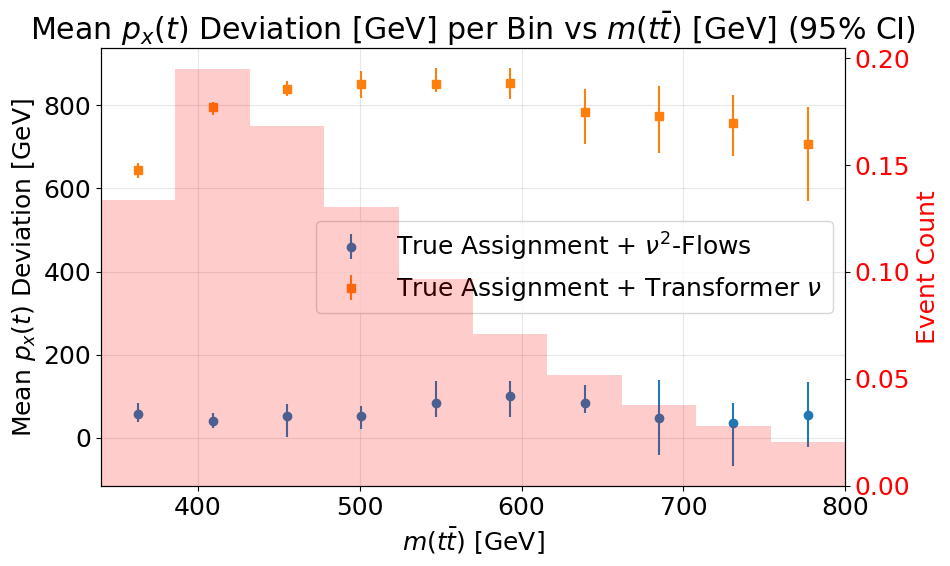

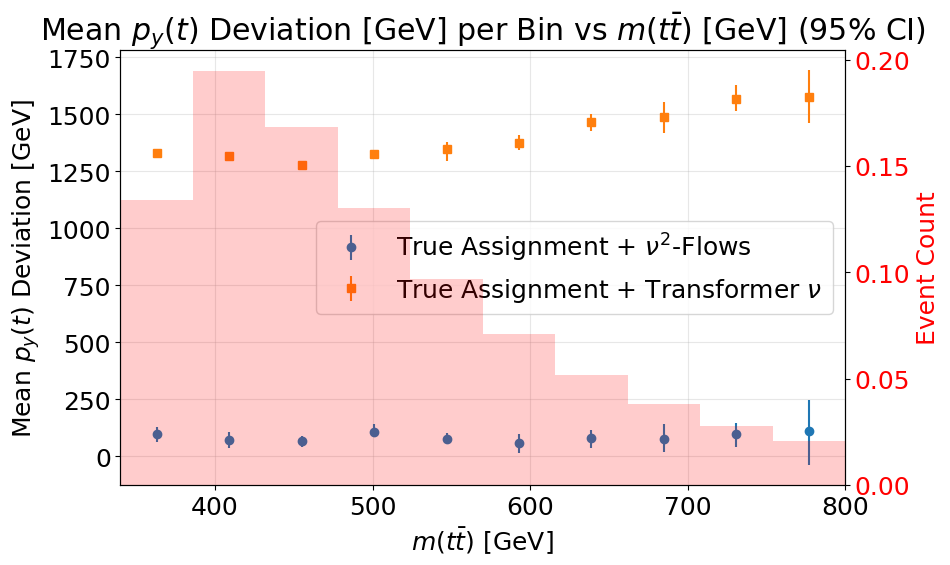

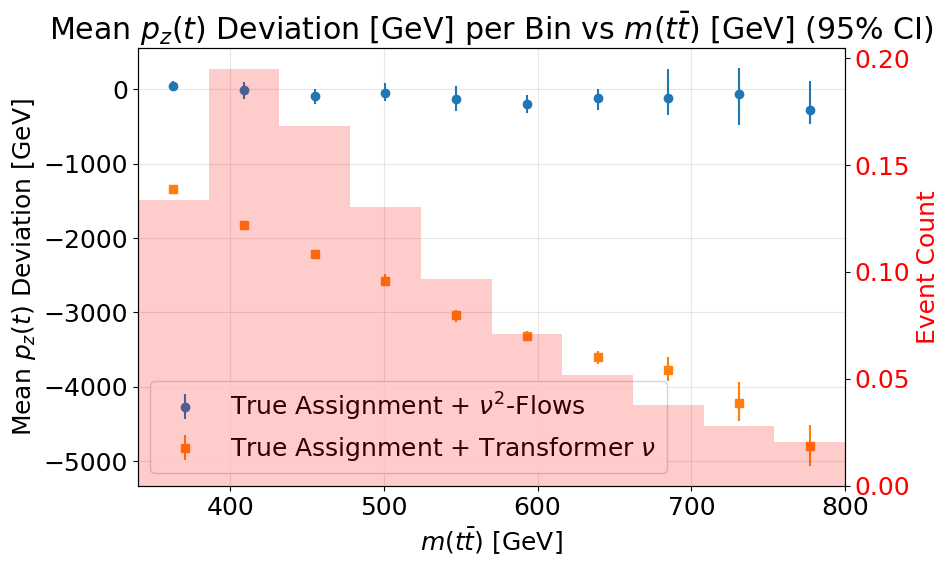

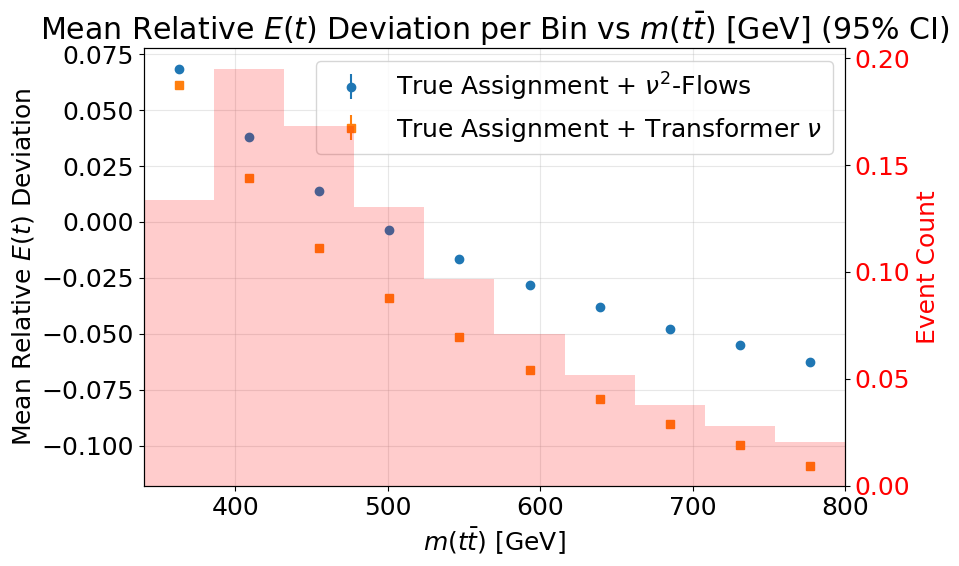

In [8]:
fig, ax = evaluator.plot_binned_variable(
    "top_px",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/top_px_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "top_py",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/top_py_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_binned_variable(
    "top_pz",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/top_pz_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_binned_variable(
    "top_energy",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/top_energy_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")

In [9]:
np.isinf(evaluator.variable_handler.compute_reconstructed_variable(0, "top_pz")).any()

Using cached reconstructed variable 'top_pz' for reconstructor True Assignment + $\nu^2$-Flows.


np.False_

Using cached reconstructed variable 'top_px' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'top_px' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'top_py' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'top_py' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'top_pz' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'top_pz' for reconstructor True Assignment + Transformer $\nu$.


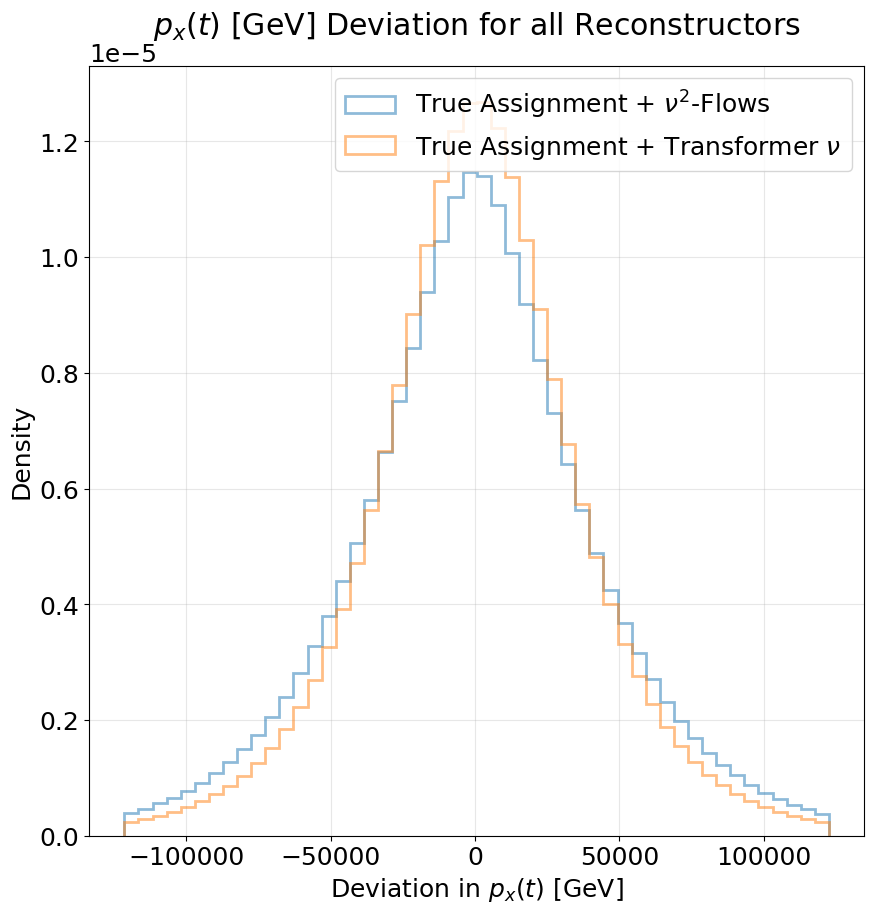

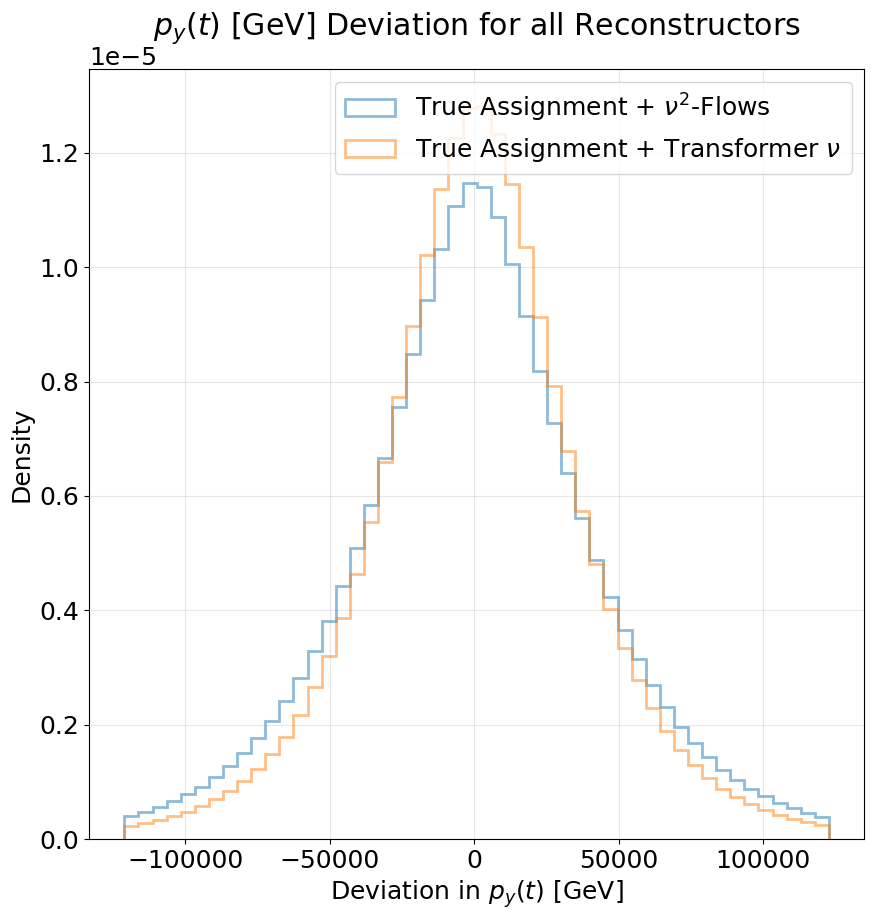

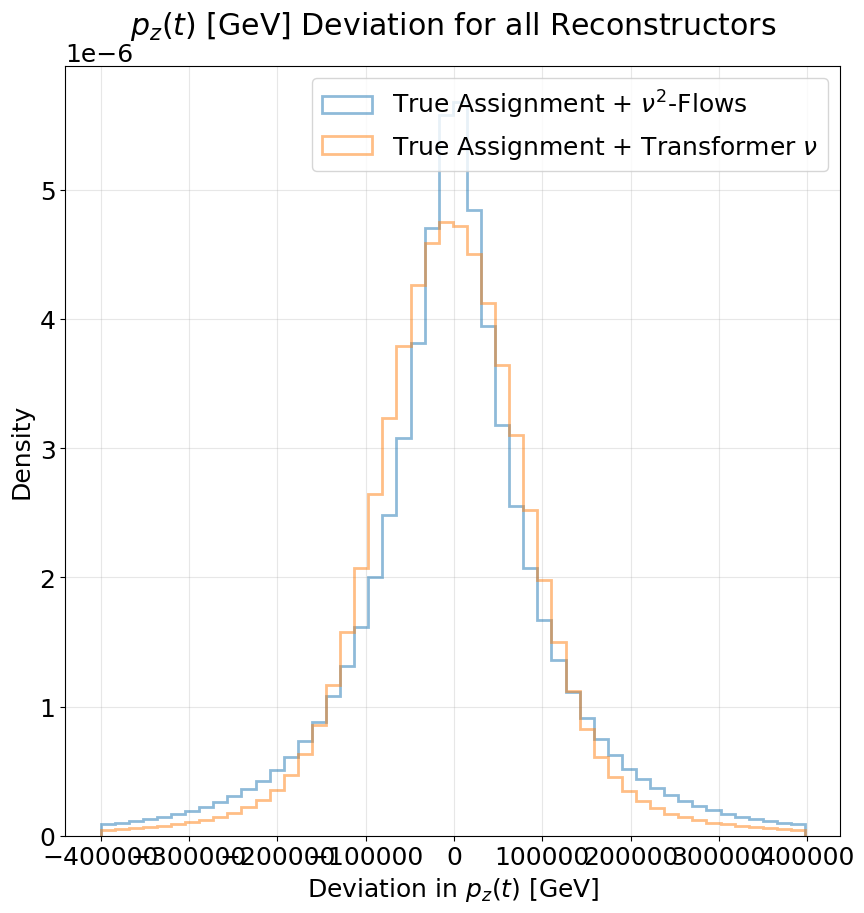

In [10]:
fig, ax = evaluator.plot_variable_deviation("top_px")
fig.savefig(f"{PLOTS_DIR}/top_px_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("top_py")
fig.savefig(f"{PLOTS_DIR}/top_py_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("top_pz")
fig.savefig(f"{PLOTS_DIR}/top_pz_deviation.pdf", bbox_inches="tight")

Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.


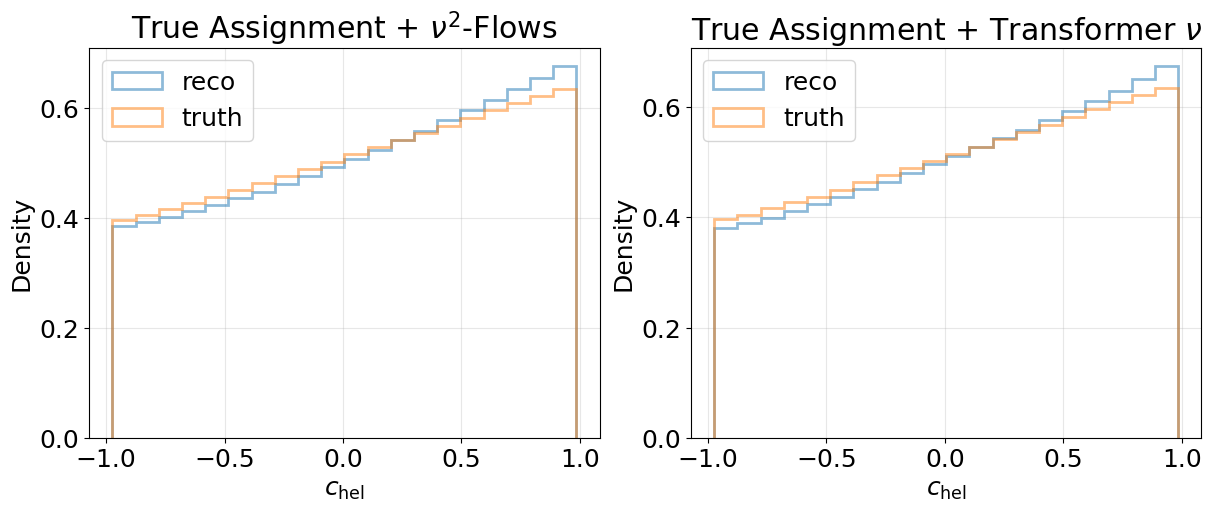

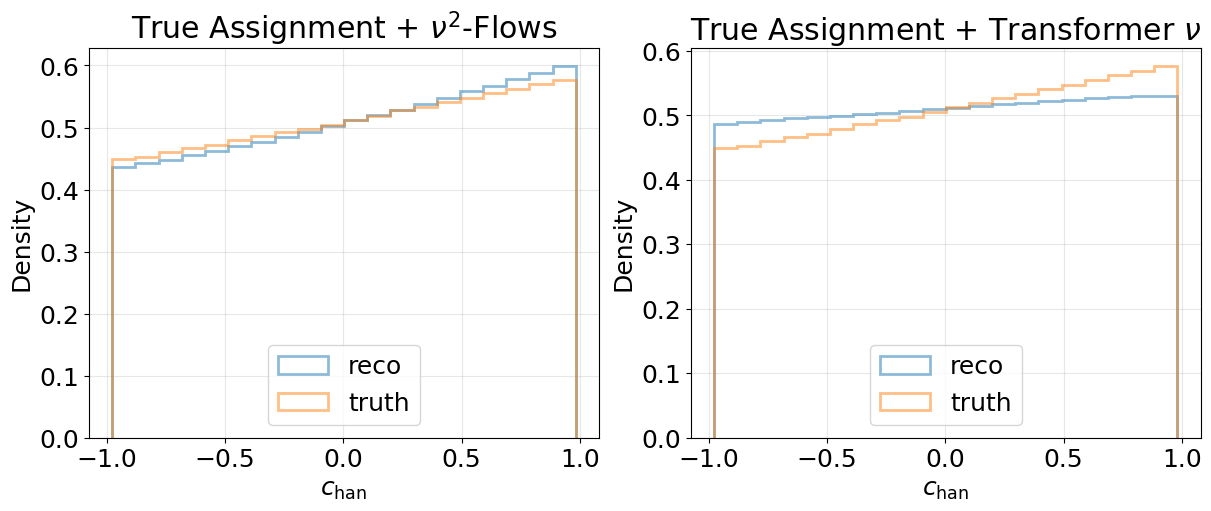

In [11]:
fig, ax = evaluator.plot_variable_distribution("c_hel", bins=20, figsize=(12, 5))
fig.savefig(f"{PLOTS_DIR}/c_hel_distribution.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_distribution("c_han", bins=20, figsize=(12, 5))
fig.savefig(f"{PLOTS_DIR}/c_han_distribution.pdf", bbox_inches="tight")

Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.


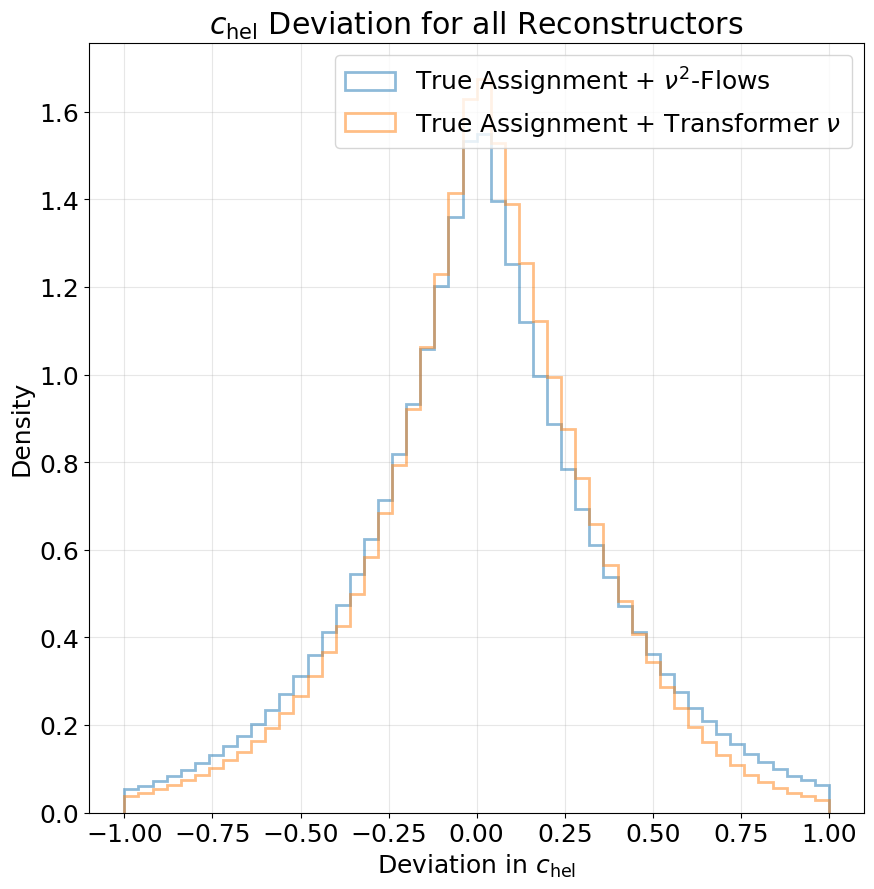

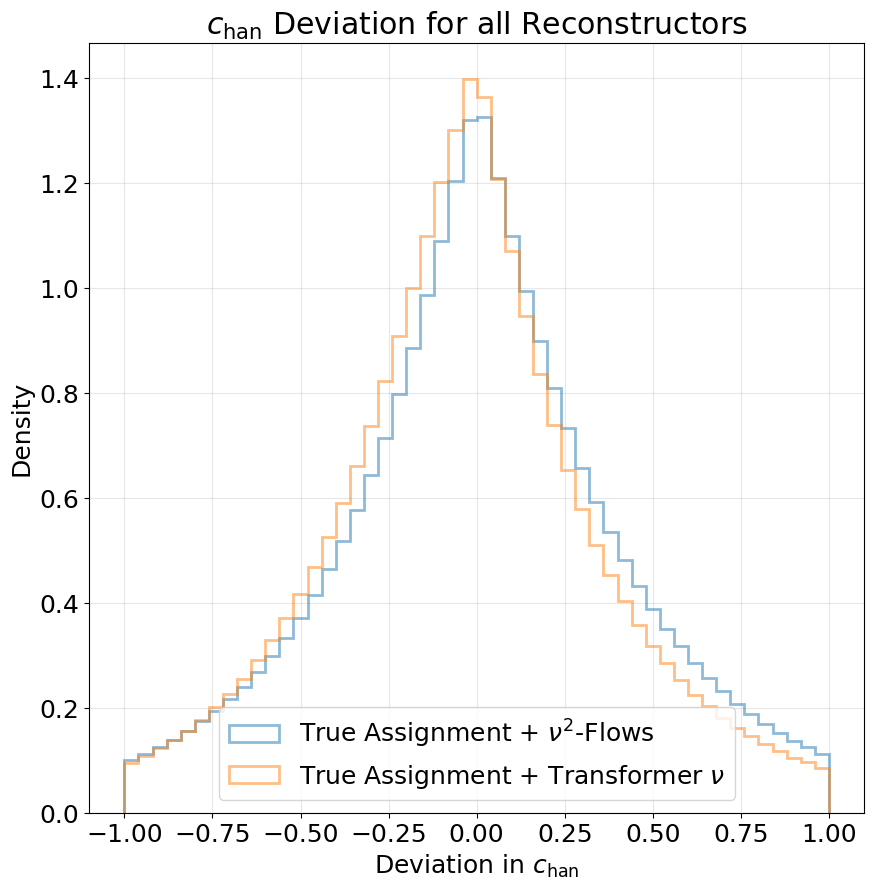

In [12]:
fig, ax = evaluator.plot_variable_deviation("c_hel", xlims=(-1, 1))
fig.savefig(f"{PLOTS_DIR}/c_hel_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("c_han", xlims=(-1, 1))
fig.savefig(f"{PLOTS_DIR}/c_han_deviation.pdf", bbox_inches="tight")

In [13]:
nu_flows_c_han = evaluator.variable_handler.compute_reconstructed_variable(1, "c_han")
transformer_nu_flows_c_han = evaluator.variable_handler.compute_reconstructed_variable(
    0, "c_han"
)
true_c_han = evaluator.variable_handler.compute_true_variable("c_han")

Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.


In [14]:
np.mean(nu_flows_c_han - true_c_han), np.mean(transformer_nu_flows_c_han - true_c_han)

(np.float64(-0.029375411891134018), np.float64(0.0118786247279334))

In [15]:
nu_flows_c_hel = evaluator.variable_handler.compute_reconstructed_variable(1, "c_hel")
transformer_nu_flows_c_hel = evaluator.variable_handler.compute_reconstructed_variable(
    0, "c_hel"
)
true_c_hel = evaluator.variable_handler.compute_true_variable("c_hel")

Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.


In [16]:
np.mean(nu_flows_c_hel - true_c_hel), np.mean(transformer_nu_flows_c_hel - true_c_hel)

(np.float64(0.017461177190640022), np.float64(0.017939134871166246))

In [17]:
transformer_nu_diff = (
    evaluator.prediction_manager.get_neutrino_predictions(0)
    - evaluator.y_test["neutrino_truth"]
)
nu_flows_nu_diff = (
    evaluator.prediction_manager.get_neutrino_predictions(1)
    - evaluator.y_test["neutrino_truth"]
)

valid_mask = (
    ~np.isnan(transformer_nu_diff).any(axis=(1, 2))
    & ~np.isnan(nu_flows_nu_diff).any(axis=(1, 2))
    & np.isfinite(transformer_nu_diff).all(axis=(1, 2))
    & np.isfinite(nu_flows_nu_diff).all(axis=(1, 2))
)

transformer_nu_diff_valid = transformer_nu_diff[valid_mask]
nu_flows_nu_diff_valid = nu_flows_nu_diff[valid_mask]

In [18]:
print(
    f"Removed {len(transformer_nu_diff) - len(transformer_nu_diff_valid)} invalid events from comparison."
)

Removed 0 invalid events from comparison.


In [19]:
np.mean(transformer_nu_diff_valid, axis=0), np.mean(nu_flows_nu_diff_valid, axis=0)

(array([[  -6.9188395,  -46.4846   , -135.09456  ],
        [ -20.210413 ,   72.62375  ,  -21.581633 ]], dtype=float32),
 array([[  974.70856,  1451.2357 , -3767.2253 ],
        [  455.0442 ,  1213.4296 , -1717.1349 ]], dtype=float32))